In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Data Transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Load Dataset
data_path = "/content/drive/MyDrive/face_image_dataset"
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# ✅ Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# ✅ CNN Architecture
class CNNBlock(nn.Module):
    def __init__(self):
        super(CNNBlock, self).__init__()
        '''self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)'''



        self.conv1 = nn.Sequential(
              nn.Conv2d(3, 32, kernel_size=3, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True)
          )
        self.conv2 = nn.Sequential(
              nn.Conv2d(32, 64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True)
          )
        self.conv3 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True)
          )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = self.conv1(x)   # [B, 32, H, W]
        x = self.conv2(x)   # [B, 64, H, W]
        x = self.conv3(x)   # [B, 128, H/2, W/2] due to stride=2
        x =  self.pool(x)
        x = self.dropout(x)
        return x

class Classifier(nn.Module):
    def __init__(self, in_channels=128, num_classes=2):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.cnn = CNNBlock()
        self.classifier = Classifier(num_classes=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        return self.classifier(x)

# ✅ Initialize Model, Loss, Optimizer
model_cnn = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0001)

# ✅ Training Function
train_losses = []
train_accuracies = []

def train_model(model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss)
        train_accuracies.append(100 * correct / total)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# ✅ Evaluation Function
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")

    # Confusion Matrix
    class_names = dataset.classes
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Run Training and Evaluation
train_model(model_cnn, criterion, optimizer_cnn, epochs=100)
evaluate_model(model_cnn)


Mounted at /content/drive


100%|██████████| 86/86 [07:49<00:00,  5.46s/it]


Epoch 1, Loss: 57.8900, Accuracy: 60.70%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 2, Loss: 57.4206, Accuracy: 62.24%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 3, Loss: 57.0104, Accuracy: 62.02%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 4, Loss: 56.7333, Accuracy: 62.32%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 5, Loss: 56.4712, Accuracy: 61.95%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 6, Loss: 56.6343, Accuracy: 61.80%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 7, Loss: 56.3584, Accuracy: 62.24%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 8, Loss: 56.5836, Accuracy: 62.76%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 9, Loss: 56.2273, Accuracy: 62.17%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 10, Loss: 55.9063, Accuracy: 62.76%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 11, Loss: 55.9690, Accuracy: 62.17%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 12, Loss: 55.9471, Accuracy: 62.32%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 13, Loss: 56.0618, Accuracy: 62.54%


100%|██████████| 86/86 [03:49<00:00,  2.67s/it]


Epoch 14, Loss: 55.6769, Accuracy: 61.58%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 15, Loss: 55.9812, Accuracy: 62.54%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 16, Loss: 55.9961, Accuracy: 62.54%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 17, Loss: 55.4851, Accuracy: 62.68%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 18, Loss: 55.5228, Accuracy: 63.71%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 19, Loss: 55.9650, Accuracy: 62.32%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 20, Loss: 55.9117, Accuracy: 62.17%


100%|██████████| 86/86 [03:49<00:00,  2.67s/it]


Epoch 21, Loss: 55.5834, Accuracy: 62.61%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 22, Loss: 55.3284, Accuracy: 63.42%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 23, Loss: 55.8545, Accuracy: 62.61%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 24, Loss: 55.7209, Accuracy: 62.10%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 25, Loss: 55.1871, Accuracy: 62.90%


100%|██████████| 86/86 [03:49<00:00,  2.67s/it]


Epoch 26, Loss: 55.2705, Accuracy: 63.64%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 27, Loss: 55.3213, Accuracy: 63.49%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 28, Loss: 55.2099, Accuracy: 63.34%


100%|██████████| 86/86 [03:51<00:00,  2.70s/it]


Epoch 29, Loss: 55.3006, Accuracy: 62.32%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 30, Loss: 55.4393, Accuracy: 62.32%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 31, Loss: 55.0086, Accuracy: 63.49%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 32, Loss: 55.4792, Accuracy: 63.93%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 33, Loss: 55.0185, Accuracy: 62.76%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 34, Loss: 55.1945, Accuracy: 63.20%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 35, Loss: 55.1013, Accuracy: 63.12%


100%|██████████| 86/86 [03:53<00:00,  2.72s/it]


Epoch 36, Loss: 54.7552, Accuracy: 63.78%


100%|██████████| 86/86 [03:54<00:00,  2.73s/it]


Epoch 37, Loss: 55.0766, Accuracy: 62.76%


100%|██████████| 86/86 [03:54<00:00,  2.73s/it]


Epoch 38, Loss: 54.7020, Accuracy: 63.05%


100%|██████████| 86/86 [03:53<00:00,  2.71s/it]


Epoch 39, Loss: 55.1025, Accuracy: 63.42%


100%|██████████| 86/86 [03:52<00:00,  2.71s/it]


Epoch 40, Loss: 54.8485, Accuracy: 63.49%


100%|██████████| 86/86 [03:53<00:00,  2.71s/it]


Epoch 41, Loss: 54.8479, Accuracy: 64.00%


100%|██████████| 86/86 [03:53<00:00,  2.71s/it]


Epoch 42, Loss: 54.3805, Accuracy: 63.78%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 43, Loss: 54.7773, Accuracy: 63.64%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 44, Loss: 54.1870, Accuracy: 65.54%


100%|██████████| 86/86 [03:52<00:00,  2.70s/it]


Epoch 45, Loss: 54.6869, Accuracy: 63.20%


100%|██████████| 86/86 [03:51<00:00,  2.70s/it]


Epoch 46, Loss: 55.0198, Accuracy: 63.27%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 47, Loss: 54.5918, Accuracy: 64.74%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 48, Loss: 54.5202, Accuracy: 65.69%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 49, Loss: 54.4951, Accuracy: 63.34%


100%|██████████| 86/86 [03:50<00:00,  2.68s/it]


Epoch 50, Loss: 54.4424, Accuracy: 63.86%


100%|██████████| 86/86 [03:54<00:00,  2.73s/it]


Epoch 51, Loss: 54.6041, Accuracy: 64.52%


100%|██████████| 86/86 [03:55<00:00,  2.73s/it]


Epoch 52, Loss: 54.2344, Accuracy: 63.71%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 53, Loss: 54.1502, Accuracy: 64.44%


100%|██████████| 86/86 [03:51<00:00,  2.69s/it]


Epoch 54, Loss: 54.2143, Accuracy: 65.25%


100%|██████████| 86/86 [03:51<00:00,  2.70s/it]


Epoch 55, Loss: 54.2949, Accuracy: 64.22%


  0%|          | 0/86 [00:00<?, ?it/s]

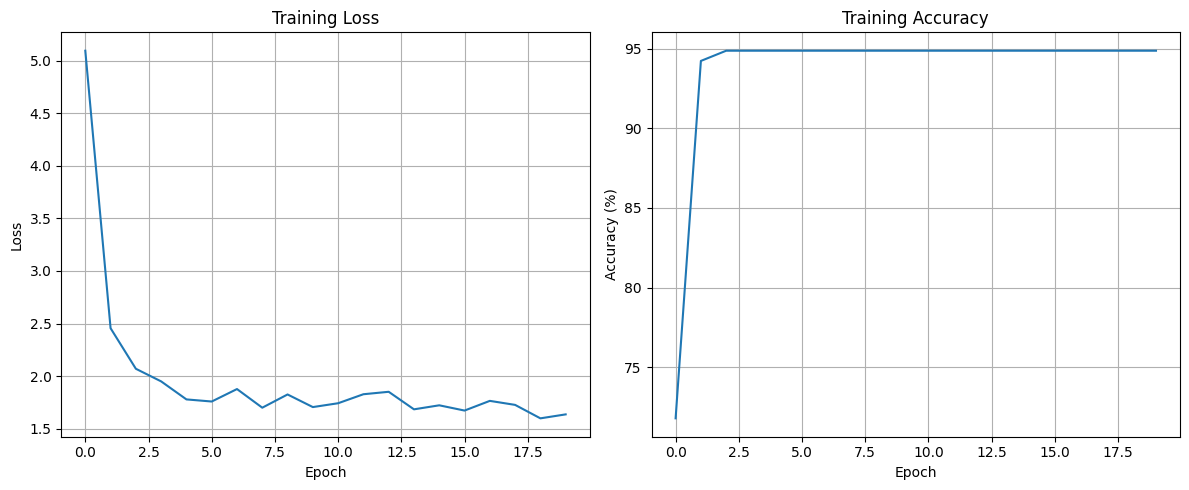

In [ ]:

    # Plot loss and accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Accuracy')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self):
        super(CNNBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # -> [B, 32, 64, 64]
        x = self.pool(torch.relu(self.conv2(x)))  # -> [B, 64, 32, 32]
        x = self.pool(x)                          # Add one more pool -> [B, 64, 16, 16]
        x = self.pool(x)                          # Optional: Add another pool -> [B, 64, 8, 8]
        x = self.dropout(x)
        return x


In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels=64, num_classes=2):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool(x).squeeze(-1).squeeze(-1)  # shape: (batch, in_channels)
        return self.fc(x)


In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels=64, num_classes=2):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.cnn = CNNBlock()
        self.classifier = Classifier(num_classes=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        return self.classifier(x)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# Mount Google Drive (if dataset is there)
from google.colab import drive
drive.mount('/content/drive')

# Path to your data (change as needed)
data_path = "/content/drive/MyDrive/face_image_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

In [ ]:
train_losses = []
train_accuracies = []

In [ ]:
# ✅ STEP 5: Training and Validation Functions
def train_model(model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs, labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss)
        train_accuracies.append(100*correct/total)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {100*correct/total:.2f}%")

In [ ]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    print(f"Validation Accuracy: {100*correct/total:.2f}%")
    class_names = dataset.classes
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Precision, Recall, F1
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
model_cnn = SimpleCNN(num_classes=2)

criterion = nn.CrossEntropyLoss()
#optimizer_mv = torch.optim.Adam(model_mobilevit.parameters(), lr=0.001)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

# Step 1: Define transformations and dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for pre-trained networks
])

# CIFAR-10 Dataset (You can use any dataset you prefer)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Step 2: Create the DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Step 3: Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 4: Initialize model, loss function, and optimizer
model_cnn = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

# Step 5: Define the training function
def train_model(model, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):  # Use the train_loader here
            inputs, labels = inputs, labels
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Step 6: Train the model
train_model(model_cnn, criterion, optimizer_cnn, epochs=20)


100%|██████████| 782/782 [01:33<00:00,  8.35it/s]


Epoch 1/6, Loss: 1.3069, Accuracy: 53.38%


100%|██████████| 782/782 [01:41<00:00,  7.67it/s]


Epoch 2/6, Loss: 0.9326, Accuracy: 67.57%


100%|██████████| 782/782 [01:38<00:00,  7.95it/s]


Epoch 3/6, Loss: 0.7853, Accuracy: 72.53%


100%|██████████| 782/782 [01:34<00:00,  8.25it/s]


Epoch 4/6, Loss: 0.6746, Accuracy: 76.55%


100%|██████████| 782/782 [01:41<00:00,  7.67it/s]


Epoch 5/6, Loss: 0.5767, Accuracy: 79.95%


100%|██████████| 782/782 [01:36<00:00,  8.09it/s]

Epoch 6/6, Loss: 0.4904, Accuracy: 82.77%


In [ ]:
print("Training Simple CNN Model")
train_model(model_cnn, criterion, optimizer_cnn, epochs=15)


Training Simple CNN Model


100%|██████████| 782/782 [01:37<00:00,  8.01it/s]


Epoch 1/3, Loss: 0.4083, Accuracy: 85.55%


100%|██████████| 782/782 [01:34<00:00,  8.24it/s]


Epoch 2/3, Loss: 0.3283, Accuracy: 88.62%


100%|██████████| 782/782 [01:37<00:00,  8.03it/s]

Epoch 3/3, Loss: 0.2670, Accuracy: 90.64%


Validation Accuracy: 62.28%


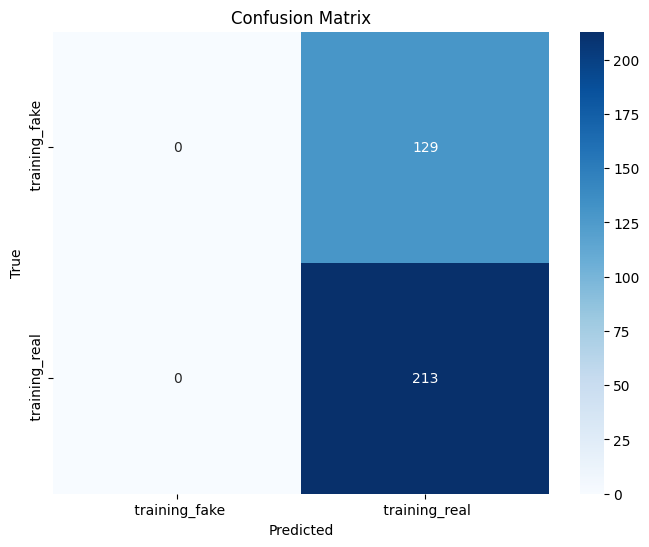


Classification Report:
                precision    recall  f1-score   support

 training_fake       0.00      0.00      0.00       129
 training_real       0.62      1.00      0.77       213

      accuracy                           0.62       342
     macro avg       0.31      0.50      0.38       342
  weighted avg       0.39      0.62      0.48       342



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate_model(model_cnn)